<a href="https://colab.research.google.com/github/kundajelab/mfinkels_work/blob/master/av/Generate_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import division, print_function

In [2]:
!pip install simdna
!pip install deeplift

     |████████████████████████████████| 634kB 3.3MB/s 
  ERROR: Failed building wheel for simdna
  Running setup.py clean for simdna
Failed to build simdna
    Running setup.py install for simdna ... done
  Created wheel for deeplift: filename=deeplift-0.6.10.0-cp36-none-any.whl size=34063 sha256=2d87638461093757b58ba2dd06dfc4605f51f2aaa918c61d4e1d1ddc2635a8be
  Stored in directory: /root/.cache/pip/wheels/3a/16/f1/d6b985cafb1dbe671cf9254d1b08c18dcd8f4487a09ff778a9
Successfully built deeplift


In [0]:
import simdna
from simdna import synthetic
import numpy as np
from collections import OrderedDict
#from simdna.util import DEFAULT_LETTER_TO_INDEX
import scipy
from scipy.stats import spearmanr, pearsonr
import deeplift
from deeplift.dinuc_shuffle import dinuc_shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [0]:
#set up the simulation
simdna.random.seed(1234)
np.random.seed(1234)

seqLength = 100

background_letter_freq = OrderedDict(
    [('A', 0.27), ('C', 0.23), ('G', 0.23), ('T', 0.27)])
letter_distribution = simdna.util.DiscreteDistribution(background_letter_freq)

def get_single_embedder(loadedMotifs, motif_name):
  return synthetic.SubstringEmbedder(
            substringGenerator=synthetic.PwmSamplerFromLoadedMotifs(loadedMotifs, motif_name),
            positionGenerator=synthetic.UniformPositionGenerator(),
            name=motif_name)

def get_embedder_or_none(loadedMotifs, motif_name):
  return synthetic.XOREmbedder(
            embedder1 = get_single_embedder(loadedMotifs = loadedMotifs, motif_name = motif_name),
            embedder2 = synthetic.RandomSubsetOfEmbedders(
                quantityGenerator = synthetic.FixedQuantityGenerator(0),
                embedders = 
                [get_single_embedder(loadedMotifs = loadedMotifs, motif_name = motif_name)]),
            probOfFirst = 0.5)

loadedMotifs = synthetic.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001)
pwm_GATA_orig = loadedMotifs.loadedMotifs["GATA_disc1"].getRows()
pwm_TAL_orig = loadedMotifs.loadedMotifs["TAL1_known1"].getRows()

embedInBackground = synthetic.EmbedInABackground(
        backgroundGenerator=synthetic.ZeroOrderBackgroundGenerator(
            seqLength=seqLength,
            discreteDistribution=letter_distribution), 
        embedders=[
            get_embedder_or_none(loadedMotifs, "GATA_disc1"),
            get_embedder_or_none(loadedMotifs, "TAL1_known1")] 
    )

numSeqs = 50000 #30K train, 10K valid, 10K test
sequenceSet = synthetic.GenerateSequenceNTimes(embedInBackground, numSeqs)

labelNames = ["has_gata", "has_tal", "has_talandgata"]

def labelingFunc(self, generatedSequence):
  has_gata = 1 if generatedSequence.additionalInfo.isInTrace("GATA_disc1") else 0
  has_tal = 1 if generatedSequence.additionalInfo.isInTrace("TAL1_known1") else 0
  has_talandgata = 1 if (has_gata and has_tal) else 0
  return [has_gata, has_tal, has_talandgata]

synthetic.printSequences("simulation.simdata", sequenceSet,
                         includeFasta=True,
                         includeEmbeddings=True,
                         labelGenerator=synthetic.LabelGenerator(
                             labelNames=labelNames,
                             labelsFromGeneratedSequenceFunction=labelingFunc),
                         prefix="sim")

In [5]:
!md5sum simulation.simdata

data = synthetic.read_simdata_file("simulation.simdata")
count_hasgata, count_hastal, count_tal_and_gata = np.sum(data.labels, axis=0)
count_only_gata = count_hasgata - count_tal_and_gata
count_only_tal = count_hastal - count_tal_and_gata
print(count_only_gata, count_only_tal, count_tal_and_gata,
      len(data.labels) - (count_only_gata + count_only_tal + count_tal_and_gata))

28490a9cd104baf7de558df0e01e7eef  simulation.simdata
12390 12430 12597 12583


In [0]:
#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels) 
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])

In [0]:
def convert_pwm_to_deltadeltaG(pwm):
  deltadeltaG = -np.log(pwm/np.array([background_letter_freq[x]
                              for x in ['A', 'C', 'G', 'T']])[None,:])
  return deltadeltaG

pwm_GATA = convert_pwm_to_deltadeltaG(pwm_GATA_orig)
pwm_TAL = convert_pwm_to_deltadeltaG(pwm_TAL_orig)

In [0]:
#do a fast PWM scan with numpy rolling statistics
# based on http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html
MU = 0 #-5
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def score_pwm(pwm, onehot_data):
  pwm = pwm.transpose((1,0)) #ACGT first
  strided_onehot = rolling_window(a=onehot_data.transpose(0,2,1),
                                  window=pwm.shape[-1])
  strided_scores = np.sum(strided_onehot*pwm[None,:,None,:],axis=(1,3))
  return strided_scores

def get_count(pwm, onehot_data):
  deltadeltaG_mat = score_pwm(pwm=pwm, onehot_data=onehot_data)
  pStormo_mat = 1.0/(1.0 + np.exp(deltadeltaG_mat - MU))
  expected_count = np.sum(pStormo_mat, axis=-1)
  return deltadeltaG_mat, expected_count

deltadeltaG_mat_GATA, expected_count_GATA = get_count(pwm_GATA, onehot_data)
deltadeltaG_mat_TAL, expected_count_TAL = get_count(pwm_TAL, onehot_data)

expected_count_neg = 100 * (expected_count_GATA + expected_count_TAL)
expected_count_pos = 60*((expected_count_GATA + expected_count_TAL)**1.5)
rng = np.random.RandomState(1234)
labels_neg = rng.poisson(lam=expected_count_neg, size=len(expected_count_neg))
labels_pos = rng.poisson(lam=expected_count_pos, size=len(expected_count_pos))

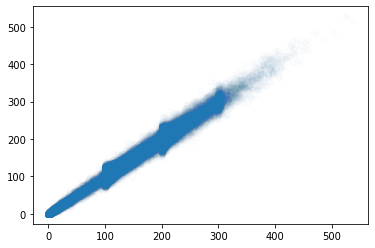

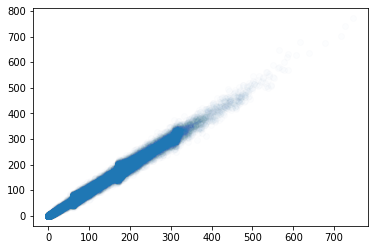

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.scatter(expected_count_neg, labels_neg, alpha=0.01)
plt.show()

plt.scatter(expected_count_pos, labels_pos, alpha=0.01)
plt.show()

In [0]:
#save the labels
neg_labels_fh = open("neg_labels.txt", "w")
neg_labels_fh.write("\n".join([str(lab)+"\t"+str(exp) for (exp, lab)
                    in zip(expected_count_neg, labels_neg)]))
neg_labels_fh.close()

#save the labels
pos_labels_fh = open("pos_labels.txt", "w")
pos_labels_fh.write("\n".join([str(lab)+"\t"+str(exp) for (exp, lab)
                    in zip(expected_count_pos, labels_pos)]))
pos_labels_fh.close()

In [11]:
!head neg_labels.txt

5	3.9556714333663376
0	0.8723493322167508
183	165.86628508719633
83	82.91478903189929
109	102.47376788600042
115	112.80948366668682
0	0.2505610132630518
109	113.12165963419002
208	235.77379484710877
142	120.82657161930747


In [12]:
!head pos_labels.txt

0	0.47204300550326533
0	0.0488862697472111
121	128.17060289394672
38	45.300109361586486
60	62.24010378600618
72	71.89019598160023
0	0.0075252597546593145
81	72.18881330157092
210	217.21736987999986
77	79.68836743977995


In [13]:
!gzip neg_labels.txt
!gzip pos_labels.txt
!gzip simulation.simdata
!du -h *

512K	neg_labels.txt.gz
508K	pos_labels.txt.gz
55M	sample_data
5.6M	simulation.fa
4.0K	simulation_info.txt
2.0M	simulation.simdata.gz
